In [1]:
import json
import os

import shutil
import base64
import requests
import pandas as pd 

from dotenv import load_dotenv
import google.generativeai as genai

In [2]:
list_validation_images = os.listdir("dataset/Bornon")
len(list_validation_images)

4100

In [3]:
files_to_copy = list_validation_images[:100]
len(files_to_copy)

100

In [4]:
source_folder = "dataset/Bornon" 
destination_folder = "dataset/validation"

In [13]:
for filename in files_to_copy:
  source_path = os.path.join(source_folder, filename)
  destination_path = os.path.join(destination_folder, filename)
  
  if os.path.isfile(source_path):
      shutil.copy2(source_path, destination_path)
    #   print(f"Copied {filename} to {destination_folder}")
  else:
      print(f"File {filename} not found in source folder.")

In [4]:
df_train = pd.read_csv("dataset/bornon_train_token.txt", delimiter="#0\s+", names=["image_name", "caption"], header=None)
df_test = pd.read_csv("dataset/bornon_test_token.txt", delimiter="#0\s+", names=["image_name", "caption"], header=None)
# df.head()

/tmp/ipykernel_11226/2659181671.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_train = pd.read_csv("dataset/bornon_train_token.txt", delimiter="#0\s+", names=["image_name", "caption"], header=None)
/tmp/ipykernel_11226/2659181671.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_test = pd.read_csv("dataset/bornon_test_token.txt", delimiter="#0\s+", names=["image_name", "caption"], header=None)


In [5]:
def consolidate(gdf):
    captions = gdf['caption'].to_list()
    return captions

In [6]:
df1 = df_train.groupby("image_name").apply(consolidate, include_groups=False).reset_index().rename(columns={0: 'captions'})
df2 = df_test.groupby("image_name").apply(consolidate, include_groups=False).reset_index().rename(columns={0: 'captions'})

In [7]:
df1.sort_values(by='image_name', key=lambda x: pd.to_numeric(x.str.rstrip('.jpg'), errors='coerce'), inplace=True)
df2.sort_values(by='image_name', key=lambda x: pd.to_numeric(x.str.rstrip('.jpg'), errors='coerce'), inplace=True)

In [8]:
df2.head()

,image_name,captions
16,11.jpg,"[কিছু বেলী ফুল দেখা যাচ্ছে ।, বালির উপর কিছু ব..."
172,20.jpg,"[একজন মানুষ দেখা যাচ্ছে ।, একজন মানুষ হাতমেলে ..."
240,24.jpg,"[তিনজন শিশু দেখা যাচ্ছে ।, তিনজন শিশুকে পুকুরে..."
302,28.jpg,"[একজন মহিলা দেখা যাচ্ছে ।, পার্কে একজন মহিলা ব..."
366,32.jpg,"[দুইজন মানুষ দেখা যাচ্ছে ।, দুইজন মানুষ নদীর প..."


In [9]:
df = pd.concat([df1, df2], axis=0)
df.tail()

,image_name,captions
505,4070.jpg,"[একটি খয়েরি রঙের টেবিল দেখা যাচ্ছে ।, টেবিলের ..."
506,4075.jpg,"[একটি খয়েরি রঙের টেবিল দেখা যাচ্ছে ।, টেবিলের ..."
507,4077.jpg,"[একটি লাল রঙের টেবিলে দেখা যাচ্ছে ।, টেবিলের উ..."
508,4084.jpg,"[একটি কালো রঙের টেবিল আছে ।, টেবিলের উপর একটি ..."
509,4089.jpg,"[একটি সাদা রঙের টেবিল আছে ।, টেবিলের উপর তিনটি..."


In [19]:
mask = df['image_name'].isin(files_to_copy)
validation = df[mask]

In [10]:
load_dotenv()

OPENAI_API = os.getenv("OPENAI_API")
GEMINI_API = os.getenv("GOOGLE_API")

### GPT-4 vision QnA and Captioning test for these images

In [11]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')        

In [15]:
def give_q_n_a(image_name, captions):
    # Path to your image
    image_path = f"dataset/Bornon/{image_name}"

    # Encode the image
    base64_image = encode_image(image_path)

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {OPENAI_API}"
    }
    payload = {
        # "model": "gpt-4-vision-preview", "gpt-4-turbo"
        "model": "gpt-4-turbo",
        # "response_format": {"type": "json_object"},
        "messages": [
            {
                "role": "user",
                "content": [
                    # {"type": "text", "text": "Caption the image explaining the contents in it. Use Bengali language to caption the image."},
                    {"type": "text", "text": f"Generate a Question and answer pair in Bengali language based on the Captions: {captions} and the image given.\
                        give me the question and answer in the following format: \
                            Q#   'QUESTION_GENERATED', \
                            A#   'ANSWER_GENERATED',\
                        Please keep in mind that always generate the question keeping the context of the captions and the image. Also keep in mind that \
                            generate everything in Bengali. Generate only one question and answer pair. \
                        "},

                    {"type": "image_url", "image_url": {"url": 
    f"data:image/jpeg;base64,{base64_image}"}}
                ]
            }
        ],
        "max_tokens": 300
    }   


    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    
    return response.json()#['choices'][0]['message']['content']


In [37]:
# df.loc[:,'Generated'] = None
# df = final_df
df[190:215]

,image_name,captions,Generated
190,229.jpg,"['দুটি মেডেল দেখা যাচ্ছে ।', 'ক্রিকেট টুর্নামে...",Q# ছবিতে কোন দুটি রঙের মেডেল দেখা যাচ্ছে?\nA# ...
191,230.jpg,"['কিছু মাংস দেখা যাচ্ছে ।', 'ইনফ্রারেড কুকারে ...",Q# ছবিতে কোন ধরনের রান্নার যন্ত্র ব্যবহার করা ...
192,231.jpg,"['একটি বাটি দেখা যাচ্ছে ।', 'একটি বাটিতে কাস্ট...",Q# ছবিতে থাকা বাটিতে কী কী উপকরণ দেখা যাচ্ছে?\...
193,232.jpg,"['পুজার দৃশ্য দেখা যাচ্ছে ।', 'পুজার মন্ডপে দে...",Q# 'ছবিটিতে কোন ধর্মীয় উৎসবের দৃশ্য দেখা যাচ্...
194,233.jpg,['একটি আলোকসজ্জায় নন্দিত মন্দির দেখা যাচ্ছে ।...,Q# ছবিতে দেখা যাওয়া মন্দিরটির আলোকসজ্জা কেন বি...
195,235.jpg,"['মনোরম প্রাকৃতিক দৃশ্য দেখা যাচ্ছে ।', 'কিছু ...",Q1: ছবিতে কোন প্রাকৃতিক উপাদানগুলি প্রধানত দেখ...
196,236.jpg,"['সমুদ্রপাড় এর দৃশ্য দেখা যাচ্ছে ।', 'সমুদ্রপ...",Q# ছবিতে দেখা যাওয়া জাহাজগুলি কি সমুদ্রে স্থি...
197,237.jpg,"['সমুদ্র দেখা যাচ্ছে ।', 'সমুদ্রে কিছু জাহাজ দ...",Q# ছবিতে সমুদ্রের উপর কী দেখা যাচ্ছে?\n\nA# ছব...
198,238.jpg,"['সমুদ্র দেখা যাচ্ছে ।', 'সমুদ্রে কিছু জাহাজ দ...",Q# ছবিতে দেখা যাচ্ছে সমুদ্রে কতগুলি জাহাজ রয়ে...
199,239.jpg,"['একজন মানুষ দেখা যাচ্ছে ।', 'হুডি পরা একজন মা...",Q# ছবিতে দেখা যাচ্ছে এই ব্যক্তি কী পরে আছেন?\n...


In [22]:
# validation.loc[:,'Generated'] = None
df = pd.read_csv("bornon-dataset.csv")


In [31]:
import time

sliced_df = df[101:400]
sliced_df.head(10)
# validation.loc[validation['image_name'] == rows['image_name'], 'Generated'] = res


,image_name,captions,Generated
101,119.jpg,"['একটি মেয়েকে দেখা যাচ্ছে ।', 'লাল শাড়ি পরা এক...",NaN
102,120.jpg,"['আবছা ভাবে একজন মানুষ ও শিশু দেখা যাচ্ছে ।', ...",NaN
103,123.jpg,"['স্টেজে কিছু মানুষ দেখা যাচ্ছে ।', 'অনেক মানু...",NaN
104,124.jpg,"['একজন মানুষ দেখা যাচ্ছে ।', 'একজন মানুষ মাথায...",NaN
105,125.jpg,"['অনেক ছেলে দেখা যাচ্ছে ।', 'কিছু বসে থাকা এবং...",NaN
106,127.jpg,"['অনেক মানুষ দেখা যাচ্ছে ।', 'একজন মানুষ মাইক ...",NaN
107,128.jpg,"['আবছাভাবে কিছু মানুষ দেখা যাচ্ছে ।', 'আবছাভাব...",NaN
108,129.jpg,"['অসংখ্য মানুষের ভীড় দেখা যাচ্ছে ।', 'একজন সা...",NaN
109,130.jpg,"['বহুতল বিশিষ্ট একটি ভবন দেখা যাচ্ছে ।', 'আকাশ...",NaN
110,131.jpg,['একটি রাস্তায় কিছু যানবাহন এবং কিছু গাছপালা দ...,NaN


In [25]:
total_tokens = 0
total_input_tokens = 0
total_output_tokens = 0

val = 1

In [14]:
final_df = pd.read_csv("bornon-dataset.csv")


final_df.isna().sum()

image_name       0
captions         0
Generated     3988
dtype: int64

In [34]:

for idx, rows in sliced_df.iterrows():
    res = (give_q_n_a(rows['image_name'], rows['captions']))
    total_input_tokens = total_input_tokens + res['usage']['prompt_tokens']
    total_output_tokens = total_output_tokens + res['usage']['completion_tokens']
    total_tokens = total_tokens + res['usage']['total_tokens']
    df.loc[df['image_name'] == str(rows['image_name']), 'Generated'] = res['choices'][0]['message']['content']
    print("done: ", val)
    val = val+1
    time.sleep(1)
    # break

done:  1
done:  2
done:  3
done:  4
done:  5
done:  6
done:  7
done:  8
done:  9
done:  10
done:  11
done:  12
done:  13
done:  14
done:  15
done:  16
done:  17
done:  18
done:  19
done:  20
done:  21
done:  22
done:  23
done:  24
done:  25
done:  26
done:  27
done:  28
done:  29
done:  30
done:  31
done:  32
done:  33
done:  34
done:  35
done:  36
done:  37
done:  38
done:  39
done:  40
done:  41
done:  42
done:  43
done:  44
done:  45
done:  46
done:  47
done:  48
done:  49
done:  50
done:  51
done:  52
done:  53
done:  54
done:  55
done:  56
done:  57
done:  58
done:  59
done:  60
done:  61
done:  62
done:  63
done:  64
done:  65
done:  66
done:  67
done:  68
done:  69
done:  70
done:  71
done:  72
done:  73
done:  74
done:  75
done:  76
done:  77
done:  78
done:  79
done:  80
done:  81
done:  82
done:  83
done:  84
done:  85
done:  86
done:  87
done:  88
done:  89
done:  90
done:  91
done:  92
done:  93
done:  94
done:  95
done:  96
done:  97
done:  98
done:  99
done:  100
done:  1

KeyError: 'usage'

In [35]:
print("total input tokens: ", total_input_tokens)
print("total output tokens: ", total_output_tokens)
print("total token count: " , total_tokens)

total input tokens:  68164
total output tokens:  14193
total token count:  82357


In [39]:
# validation['Generated'] = validation['image_name'].apply(res)
# res
df.isna().sum()

image_name       0
captions         0
Generated     3876
dtype: int64

In [41]:
float(68164) * float(0.00001)

0.68164

In [42]:
float(14193) * float(30.0/1000000)

0.42579

In [43]:
0.68164 + 0.42579

1.10743

In [38]:
df.to_csv("bornon-dataset.csv", index = False)

In [40]:
res

{'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.',
  'type': 'insufficient_quota',
  'param': None,
  'code': 'insufficient_quota'}}

In [24]:
import textwrap
from IPython.display import display
from IPython.display import Markdown

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

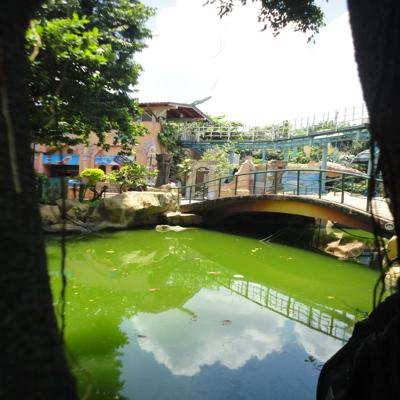

In [27]:

import PIL.Image

img = PIL.Image.open('dataset/Bornon/1.jpg')
img

In [277]:
genai.configure(api_key=GEMINI_API)

In [278]:
model = genai.GenerativeModel('gemini-1.0-pro-vision-latest')

In [296]:
def gemini_give_q_n_a(image, captions):
    response = model.generate_content([f"Generate a Question and answer pair in Bengali language based on the Captions: {captions} and the image given.\
                            give me the question and answer in the following format: \
                                Q: 'QUESTION_GENERATED',\
                                A: 'ANSWER_GENERATED',\
                            Please keep in mind that always generate the question keeping the context of the captions and the image. Also keep in mind that \
                                generate everything in Bengali \
                            ", image], stream=True)
    response.resolve()
    
    return response.text

In [298]:
# to_markdown(response.text)
import time

In [290]:
type(response.text)

str

In [334]:
sliced_df = validation[95:100]

In [335]:
for idx, rows in sliced_df.iterrows():
    image_path = f"dataset/validation/{rows['image_name']}"
    img = PIL.Image.open(image_path)
    print((rows['image_name']), rows['captions'])
    res = gemini_give_q_n_a(img , rows['captions'])
    validation.loc[validation['image_name'] == str(rows['image_name']), 'Gemini_generated'] = res
    # print(res)
    time.sleep(3)
    # break

3008.jpg ['কিছু হাঁস দেখা যাচ্ছে ।', 'একটি মা হাঁস ও কিছু হাঁস ছানা রয়েছে ।', 'ঘাসের ওপর একটি মা হাঁস ও কিছু হাঁস ছানা হেটে যাচ্ছে ।', 'অনেকগুলো বাচ্চা হাঁস ও একটি মা হাঁস হেটে যাচ্ছে ।', 'ঘাসে ওপর কিছু হাঁস হেটে যাচ্ছে ।']
3269.jpg ['চিকিৎসা সরঞ্জাম দেখা যাচ্ছে ।', 'অনেকগুলো ইনজেকশন দেখা যাচ্ছে ।', 'মোড়ককৃত ইনজেকশন দেখা যাচ্ছে ।', 'মোড়ককৃত চিকিৎসা সরঞ্জাম ।', 'সবুজ রঙের ইনজেকশন ।']
3727.jpg ['ছবিতে একটি ফুল দেখা যাচ্ছে ।', 'ফুলটির রং হালকা হলুদ ।', 'ছবির ফুলটির নাম জবা ।', 'ফুলটি দেখতে খুবই সুন্দর ।', 'ফুলটির রং হালকা হলুদ ।']
3735.jpg ['একটি খয়েরি রঙের টেবিল আছে ।', 'টেবিলের উপর একটি বাতি রয়েছে ।', 'বাটিটি দেখতে গোল ।', 'বাটির মধ্যে অনেক গুলি ডিম্ আছে ।', 'একটি খয়েরি রঙের টেবিল আছে ।']
3877.jpg ['দুজন মানুষ বসে পানির উপর দুটি হাস ভাসতে দেখছে ।', 'দুটি মানুষ পানির উপর দুটি হাস ভাসা দেখছে ।', 'দুটি হাসের ভাসমান দৃশ্য দুজন মানুষ দেখছে ।', 'দুটি হাস ভাসতে দেখছে দুজন মানুষ ।', 'দুজন মানুষ এবং দুটি হাস রয়েছে ।']


In [336]:
validation.head(10)

,image_name,captions,Generated,Gemini_generated
3151,65.jpg,"[মঞ্চে নিত্য পরিবেষণ করছে একজন মেয়ে ।, মঞ্চে ন...",Q: 'মঞ্চে কি ধরনের পরিবেষণ করছে এই মেয়েটি?'\nA...,Q: মঞ্চে নিত্য পরিবেশণ করছে কে ?\nA: মঞ্চে নি...
426,145.jpg,"[কিছু ফুল গাছ দেখা যাচ্ছে ।, ঘাসের উপর কিছু ফু...",Q: 'ছবিতে কোন ধরনের ফুল গাছ দেখা যাচ্ছে?'\nA: ...,Q: ছবিটিতে কি দেখা যাচ্ছে?\nA: ছবিটিতে গাঁদা ...
757,181.jpg,"[একটি ছায়া দেখা যাচ্ছে ।, একটি ছায়া হাত উপরে ক...",Q: 'ছবিতে দেখা যাচ্ছে ছায়াটি কি করছে?'\nA: 'ছা...,None
786,184.jpg,"[একটি ছেলে দেখা যাচ্ছে ।, কাপড়ের পিছনে একটি ছে...",Q: ছবিতে ছেলেটি কোন ধরনের পোশাক পরে আছে?\nA: ছ...,None
842,190.jpg,"[প্রাতিষ্ঠানিক একটি অনুষ্ঠান ।, প্রাতিষ্ঠানিক ...",Q: 'এই ছবিতে দেখা যায় যে লোকজন কোন ধরণের অনুষ্...,Q: ছবিতে কি দেখা যাচ্ছে?\nA: ছবিতে একটি প্রাত...
981,205.jpg,"[একটি পাহাড় দেখা যাচ্ছে ।, একটি পাহাড় এর উপর...",Q: 'ছবিতে পাহাড়ের সিঁড়ির উপর কি জিনিসটি দেখা...,Q: ছবিটিতে কি দেখা যাচ্ছে?\nA: ছবিটিতে একটি প...
1109,219.jpg,"[বহুতল বিশিষ্ট কিছু দালান দেখা যাচ্ছে ।, মেঘলা...",Q: 'ছবিতে আকাশের অবস্থা কী?'\nA: 'ছবিতে আকাশ ম...,Q: ছবিটিতে কি দেখা যাচ্ছে?\nA: ছবিটিতে মেঘলা ...
1118,220.jpg,"[কিছু নাস্তার প্লেট দেখা যাচ্ছে ।, একটি ফ্লোর ...",Q: 'ছবিতে নাস্তার প্লেটগুলি কোথায় রাখা হয়েছে...,Q: ছবিটিতে কি কি দেখা যাচ্ছে ?\nA: ছবিটিতে এক...
2652,382.jpg,"[একটি বাটিতে অনেকগুলো পুলি পিঠা দেখা যাচ্ছে ।,...",Q: 'ছবিতে কোন ধরনের পিঠা দেখা যাচ্ছে?'\nA: 'ছব...,Q: এটি কি?\nA: এটি পুলি পিঠা।
2790,396.jpg,"[রাতের আলোকিত ব্যস্ত একটি রাস্তা ।, কৃত্রিম আল...","Q: 'ছবিতে দেখা যাচ্ছে, রাতের বেলা যে রাস্তাটি ...",Q: রাতের আলোকিত ব্যস্ত এই সড়কটি কোথায় অবস্থিত...


In [338]:
validation.isna().sum()

image_name          0
captions            0
Generated           0
Gemini_generated    2
dtype: int64

In [28]:
datapath = "dataset/Bornon"

In [29]:
images = os.listdir(datapath)

In [30]:
for i in images:
    img = PIL.Image.open(f'{datapath}/{i}')
    if img.__dict__['_size'] != (400, 400):
        print(img.height, img.width)    
        # print(img.__dict__['_size'])

### Bornon Dataset
each image size is 400*400. 
and 